In [154]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import emcee
import corner

import sys
sys.path.append("../")
from pyACC.cosmology import Dc_w0waCDM

In [155]:
def hubble_function(z,Omega_m,Omega_r,w0,wa,H0):
    DE_contribution=(1+z)**(3*(1+w0+wa))*np.exp(-3*wa*z/(1+z))
    return H0*np.sqrt(Omega_m*(1+z)**3+Omega_r*(1+z)**4+(1-Omega_m-Omega_r)*DE_contribution)#(1+z)**(3*(1+w0+wa))*np.exp(-3*wa*z/(1+z)))

In [156]:
file_path = 'lcparam_full_long.txt' #'lcparam_full_long.txt' #'lcparam_DS17f.txt'

with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

z_data = data['zcmb'].values
mb = data['mb'].values #B-band peak magnitude
dmb = data['dmb'].values

Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

In [157]:
#fixing H0
H0=68

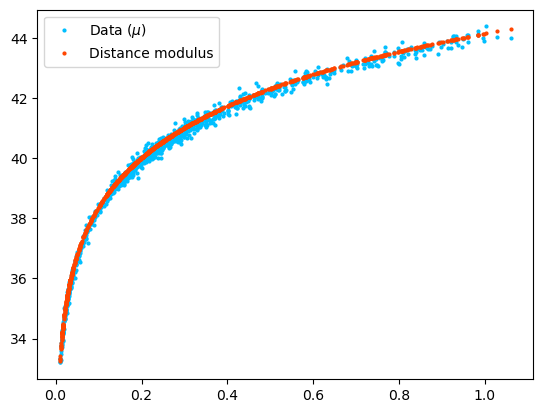

In [158]:
def get_mu(z,H0,Omega_m,Omega_r,w0,wa):
    #z=np.linspace(np.min(z),np.max(z),1000)
    comoving_distance=[]
    distance_modulus=[]
    '''
    for i in range(len(z)):
        comoving_distance.append(Dc_w0waCDM(hubble_function,z[i],Omega_m,Omega_r,w0,wa,H0))
        #print(comoving_distance[i])
        if comoving_distance[i]<=0:
            print(f"Invalid distance value: {comoving_distance[i]} for index {i} with redshift {z[i]}")
        distance_modulus.append(5*np.log10(comoving_distance[i]*(1+z[i]))+25)
        #print(distance_modulus[i])
    '''
    #'''
    for i in range(len(z)):
        # Compute comoving distance
        dc = Dc_w0waCDM(hubble_function, z[i], Omega_m, Omega_r, w0, wa, H0)
        comoving_distance.append(dc)

        # Calculate distance * (1 + z)
        distance = dc * (1 + z[i])
        if distance <= 0:
            print(f"Error at index {i}: Invalid distance value {distance} for comoving_distance {dc} and redshift {z[i]}")
            sys.exit("Stopping execution due to invalid distance value.")

        # Compute distance modulus
        modulus = 5 * np.log10(distance) + 25
        distance_modulus.append(modulus)
    #'''
    return np.array(distance_modulus)

#distance modulus of the data: mu_data=mb-M with M the absolute magnitude of a type Ia supernova, so M=-19.3
M=-19.3
mu_data=mb-M

plt.plot(z_data,mu_data,'o',markersize=2,color='deepskyblue',label='Data ($\mu$)')
plt.plot(z_data,get_mu(z_data,H0,0.319,0,-1,0),'o',markersize=2,color='orangered',label='Distance modulus')
plt.legend()
plt.show()

In [159]:
def log_prior(params):
    Omega_m, Omega_r, w0, wa = params
    if 0 < Omega_m < 1 or -1e-3 < Omega_r < 1 or -2 < w0 < 0 or -2 < wa < 2:
        return 0
    '''
    if 0 < Omega_m < 1:
        print('Omega_m')
        return 0
    if 0 < Omega_r < 1:
        print('Omega_r')
        return 0
    if -3 < w0 < 0:
        print('w0')
        return 0
    if -3 < wa < 3:
        print('wa')
        return 0
    '''
    return -np.inf

In [160]:
def log_likelihood(params,z,d,cov_inv):
    Omega_m,Omega_r,w0,wa=params
    if Omega_m<0:
        #print(f"Omega_m out of bounds: {Omega_m}")
        return -np.inf
    if Omega_r<0:
        #print(f"Omega_r out of bounds: {Omega_r}")
        return -np.inf
    mu=get_mu(z,H0,Omega_m,Omega_r,w0,wa)
    diff=d-mu
    #return -0.5 * diff @ cov_inv @ diff
    term1 = -0.5 * diff @ cov_inv @ diff
    term2 = 0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    if np.any(np.isnan(params)):
        print(f"NaN value found in params: {params}")
        return -np.inf
    return term1 + term2

In [161]:
def log_posterior(params,z,d,cov_inv):
    prior = log_prior(params)
    #check for NaNs
    if any(np.isnan(params)):
        print(f"NaNs in params: {params}")
    if np.isnan(prior):
        print(f"NaN in prior: {prior}")
    if np.isnan(log_likelihood(params,z,d,cov_inv)):
        print(f"NaN in likelihood: {log_likelihood(params,z,d,cov_inv)}")
        return prior
    if np.isfinite(prior):
        return prior + log_likelihood(params,z,d,cov_inv)
    return prior

In [162]:
def chi(params,z,d,cov_inv):
    return -2*log_posterior(params,z,d,cov_inv)

In [163]:
initial_guess = [0.319, 0, -0.5, -1]

#result = minimize(lambda params: -log_likelihood(params,z_data,mu_data,Sigma_inv), initial_guess, method='Powell')
result = minimize(chi, initial_guess, args=(z_data, mu_data, Sigma_inv), method='Powell')
best_fit_params = result.x

mu_model_best = get_mu(z_data, H0, *best_fit_params)

/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2577: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)


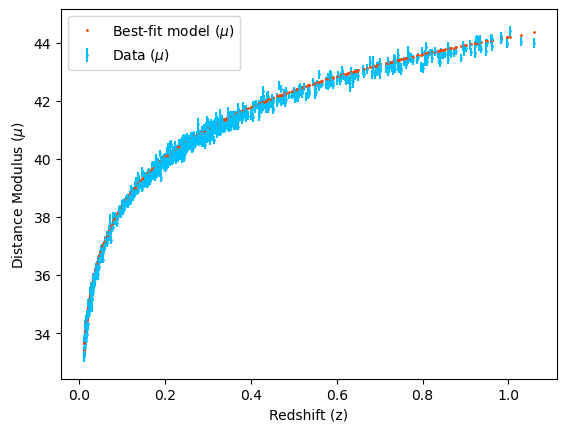

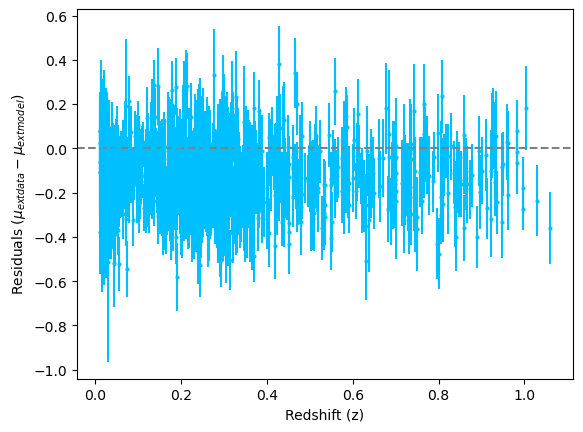

--------------------------------------
Best-fit parameters:
Omega_m: 0.014147581342844056
Omega_r: 0.027764886688521683
w0: -0.8539941323107356
wa: 1.1657550271043726
--------------------------------------
Chi-square: 1011.1558758426315
Degrees of freedom: 1018
Reduced chi-square: 0.9932768917904042
--------------------------------------


In [ ]:
plt.errorbar(z_data, mu_data, yerr=dmb, fmt='o', markersize=1, color='deepskyblue', label='Data ($\mu$)')
plt.plot(z_data, mu_model_best, 'o', markersize=1, color='orangered', label='Best-fit model ($\mu$)')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend()
plt.show()

residuals = mu_data - mu_model_best
plt.errorbar(z_data, residuals, yerr=dmb, fmt='o', markersize=2, color='deepskyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Redshift (z)')
plt.ylabel('Residuals ($\mu_{\text{data}} - \mu_{\text{model}}$)')
plt.show()

print("--------------------------------------")
print("Best-fit parameters:")
print("Omega_m:", best_fit_params[0])
print("Omega_r:", best_fit_params[1])
print("w0:", best_fit_params[2])
print("wa:", best_fit_params[3])
print("--------------------------------------")
chi2 = -2 * log_posterior(best_fit_params, z_data, mu_data, Sigma_inv)
print("Chi-square:", chi2)
print("Degrees of freedom:", len(z_data) - len(best_fit_params))
print("Reduced chi-square:", chi2 / (len(z_data) - len(best_fit_params)))
print("--------------------------------------")

In [ ]:
# Initialize the MCMC sampler
initial = np.array([0.319, 0, -0.5, -1])
ndim = len(initial)
nwalkers = 50
#pos = initial + 1e-1 * np.random.randn(nwalkers, ndim)

# Separate standard deviations for different parameter groups
std_Om0 = 1e-2
std_Omr = 1e-7
std_w0_wa = 1e-1

# Create the initial positions with different standard deviations
pos = np.empty((nwalkers, ndim))
pos[:, 0] = initial[0] + std_Om0 * np.random.randn(nwalkers)
pos[:, 1] = initial[1] + std_Omr * np.random.randn(nwalkers)
pos[:, 2] = initial[2] + std_w0_wa * np.random.randn(nwalkers)
pos[:, 3] = initial[3] + std_w0_wa * np.random.randn(nwalkers)


#'''
# Check initial likelihoods
for i in range(nwalkers):
    print(log_likelihood(pos[i], z_data, mu_data, Sigma_inv))

# Check initial posteriors
for i in range(nwalkers):
    print(log_posterior(pos[i], z_data, mu_data, Sigma_inv))
#'''

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z_data, mu_data, Sigma_inv))

-inf
-632.0576782034839
-632.7304329227208
-inf
-inf
-564.8319287567633
-inf
-inf
-inf
-inf
-649.3238195913126
-inf
-inf
-518.5266418908443
-inf
-628.0568193730101
-inf
-625.3091704093663
-inf
-inf
-inf
-614.1888868847685
-inf
-inf
-inf
-683.7118939389844
-644.9334419575836
-inf
-600.7237775125817
-619.1715290420336
-inf
-inf
-736.331814794806
-inf
-inf
-675.1995713451438
-inf
-inf
-inf
-inf
-610.9994220759546
-601.365818284154
-626.1669627505887
-546.4755201502308
-inf
-inf
-inf
-inf
-668.5538933736916
-inf
-inf
-632.0576782034839
-632.7304329227208
-inf
-inf
-564.8319287567633
-inf
-inf
-inf
-inf
-649.3238195913126
-inf
-inf
-518.5266418908443
-inf
-628.0568193730101
-inf
-625.3091704093663
-inf
-inf
-inf
-614.1888868847685
-inf
-inf
-inf
-683.7118939389844
-644.9334419575836
-inf
-600.7237775125817
-619.1715290420336
-inf
-inf
-736.331814794806
-inf
-inf
-675.1995713451438
-inf
-inf
-inf
-inf
-610.9994220759546
-601.365818284154
-626.1669627505887
-546.4755201502308
-inf
-inf
-inf
-

In [ ]:
'''
#i want to do a sampler with the best fit parameters as initial guess
pos = np.empty((nwalkers, ndim))
pos[:, 0] = best_fit_params[0] + std_Om0_Omr * np.random.randn(nwalkers)
pos[:, 1] = best_fit_params[1] + std_Om0_Omr * np.random.randn(nwalkers)
pos[:, 2] = best_fit_params[2] + std_w0_wa * np.random.randn(nwalkers)
pos[:, 3] = best_fit_params[3] + std_w0_wa * np.random.randn(nwalkers)

nsteps = 1000
sampler.run_mcmc(pos, nsteps, progress=True)

# Plot the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ['Omega_m', 'Omega_r', 'w0', 'wa']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

# Plot the corner plot
import corner
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels, truths=best_fit_params)
plt.show()
'''

'\n#i want to do a sampler with the best fit parameters as initial guess\npos = np.empty((nwalkers, ndim))\npos[:, 0] = best_fit_params[0] + std_Om0_Omr * np.random.randn(nwalkers)\npos[:, 1] = best_fit_params[1] + std_Om0_Omr * np.random.randn(nwalkers)\npos[:, 2] = best_fit_params[2] + std_w0_wa * np.random.randn(nwalkers)\npos[:, 3] = best_fit_params[3] + std_w0_wa * np.random.randn(nwalkers)\n\nnsteps = 1000\nsampler.run_mcmc(pos, nsteps, progress=True)\n\n# Plot the chains\nfig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)\nsamples = sampler.chain\nlabels = [\'Omega_m\', \'Omega_r\', \'w0\', \'wa\']\n\nfor i in range(ndim):\n    ax = axes[i]\n    ax.plot(samples[:, :, i], "k", alpha=0.3)\n    ax.set_xlim(0, len(samples))\n    ax.set_ylabel(labels[i])\n    ax.yaxis.set_label_coords(-0.1, 0.5)\n\naxes[-1].set_xlabel("step number")\nplt.show()\n\n# Plot the corner plot\nimport corner\nflat_samples = sampler.get_chain(discard=100, thin=15, flat=True)\nfig = corner.corner(fl

In [ ]:
# Run the MCMC sampler
nsteps = 500
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=10,thin=10,flat=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/marigalla/anaconda3/envs/acc-env/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [1:46:58<00:00,  6.42s/it]


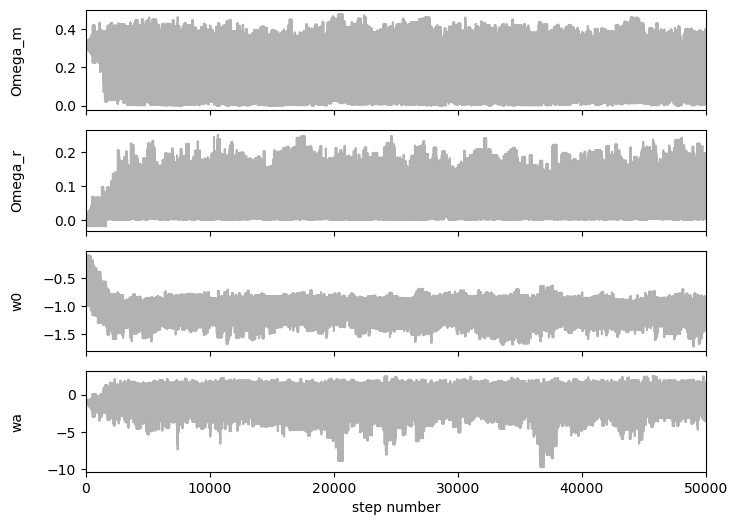

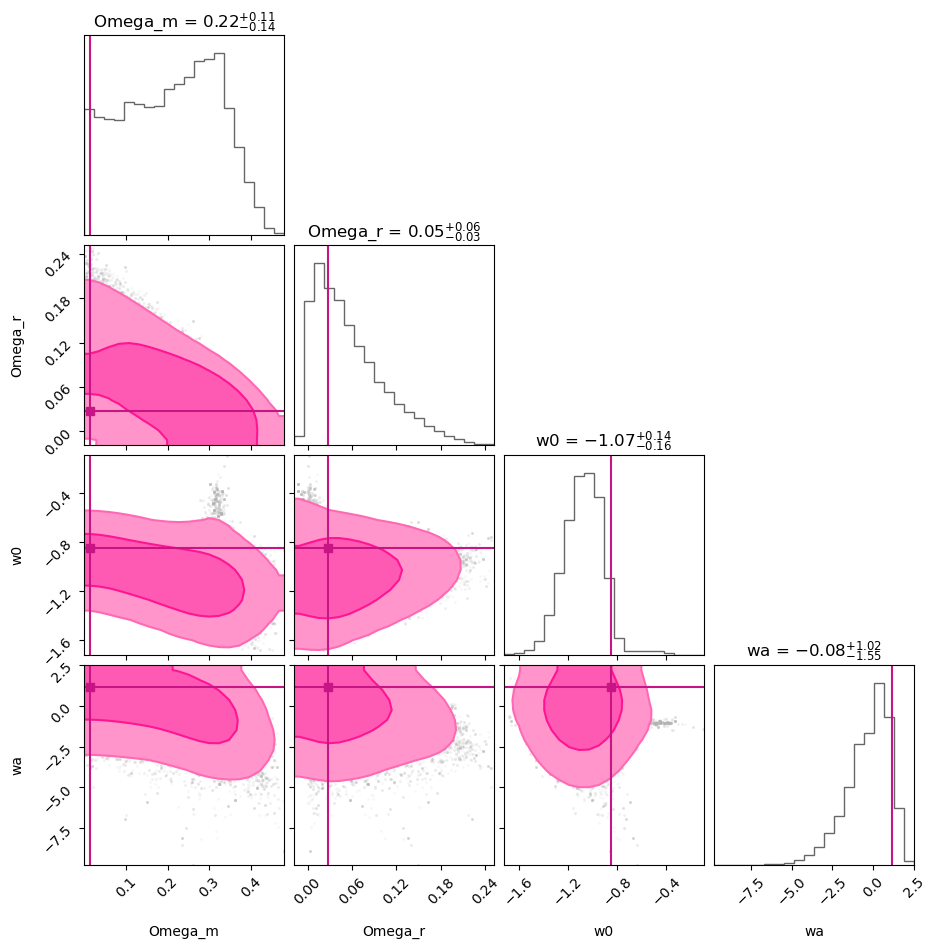

In [ ]:
reshaped_samples = samples.reshape(-1, samples.shape[-1])
#plot the chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(8, 6), sharex=True)
samples = sampler.get_chain()
labels = ["Omega_m", "Omega_r", "w0", "wa"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(reshaped_samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(reshaped_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

#'mediumvioletred'
#'hotpink', 'deeppink'

#'midnightblue'
#'deepskyblue', 'dodgerblue'

level_colors = ['hotpink', 'deeppink']

contourf_kwargs = {
    "colors": ['white', 'hotpink', 'deeppink'],  # Colors for the filled contours
    "alpha": 0.7  # Transparency of the filled contours
}
fig = corner.corner(reshaped_samples,
                    labels=labels,
                    truths=best_fit_params,
                    truth_color='mediumvioletred',
                    plot_contours=True,
                    fill_contours=True,
                    levels=[0.68, 0.95],
                    smooth=2.0,
                    show_titles=True,
                    title_fmt=".2f",
                    title_kwargs={"fontsize": 12},
                    hist_kwargs={"density": True, "alpha": 0.6},
                    contour_kwargs={"colors": level_colors},
                    contourf_kwargs=contourf_kwargs
                    )
    
plt.show()

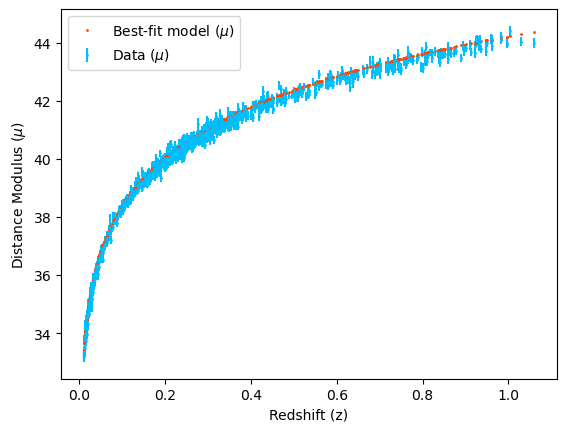

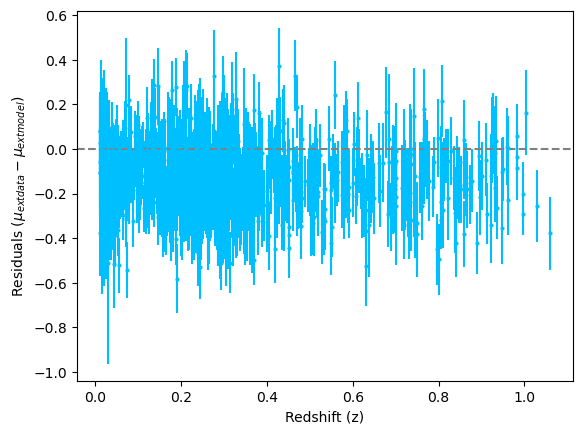

In [ ]:
#plot the best fit model
best_fit_params_mcmc = np.mean(reshaped_samples, axis=0)
best_fit_params_mcmc_std = np.std(reshaped_samples, axis=0)
mu_model_best_mcmc = get_mu(z_data, H0, *best_fit_params_mcmc)

plt.errorbar(z_data, mu_data, yerr=dmb, fmt='o', markersize=1, color='deepskyblue', label='Data ($\mu$)')
plt.plot(z_data, mu_model_best_mcmc, 'o', markersize=1, color='orangered', label='Best-fit model ($\mu$)')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.legend()
plt.show()

#plot the residuals
residuals_mcmc = mu_data - mu_model_best_mcmc
plt.errorbar(z_data, residuals_mcmc, yerr=dmb, fmt='o', markersize=2, color='deepskyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Redshift (z)')
plt.ylabel('Residuals ($\mu_{\text{data}} - \mu_{\text{model}}$)')
plt.show()

In [ ]:
print("--------------------------------------")
print("Best-fit parameters (MCMC):") #with errors
print("Omega_m:", best_fit_params_mcmc[0], "+-", best_fit_params_mcmc_std[0])
print("Omega_r:", best_fit_params_mcmc[1], "+-", best_fit_params_mcmc_std[1])
print("w0:", best_fit_params_mcmc[2], "+-", best_fit_params_mcmc_std[2])
print("wa:", best_fit_params_mcmc[3], "+-", best_fit_params_mcmc_std[3])
print("--------------------------------------")

--------------------------------------
Best-fit parameters (MCMC):
Omega_m: 0.20570562132958276 +- 0.11150797608782628
Omega_r: 0.05797825805992062 +- 0.04690518837853762
w0: -1.0825521920198977 +- 0.15121715975921426
wa: -0.31860082356884456 +- 1.3590043535983931
--------------------------------------
